jupyter nbconvert --to notebook --execute Model.ipynb --ExecutePreprocessor.timeout=-1 --ExectuePreprocessor.kernel_name=ILWA

# GRU (LSTM/RNN) Architecture and Training

We have time series data, so we should use a time series based neural network.  
Recurrent NNs are a standard sequence based model, but suffers from vanishing gradient etc.  
Alternatively LSTM (long short term memory) often out performs RNNs, and are better at learning long term dependencies.  
This would make an LSTM ideal for us, where we want the model to learn how to take into account say previous years and stuff.  
However, LSTMs are somewhat complicated, and we don't have a ton of data.  
An alternative is a GRU (grated recurrent unit), which is a little simpler than a default LSTM, which may be desirable given our small dataset.  
Because GRUs are trained on an arbituary sequence of inputs, the various training stages can be simplified significantly.  


## General Architectures

The model architecture would be quite simple.
First is a single GRU layer, 36 dim input (for each day), 256 dim hidden layer (to hopefully accomodate long sequences), 1 GRU layer (just for simplicity), with some drop out.  
This GRU layer will then feed into a single linear layer 256 -> 2.  
So the network will look like Dx36 -> GRU -> 256 -> 2, where D is the number of days.  

## Training Phases

Because sequences can be of arbitrary length, we can just have the training phases be of increasingly long periods of time.

1. Weekly (7 days). Should allow network to learn how to translate climate variables to approximate daily elevations.
2. Monthly (31 days). "    " learn how climate variables across a whole month can effect elevation.
3. Semiannual (186 days) "    " learn more across a longer time period.
4. Annual (365 days)
5. Biannual (730 days)
6. Semidecade (1825)
7. Decade (3650 days)
8. Bidecade (7300 days)

The number of observations in each training phase are:

1. 14603
2. 14579
3. 14424
4. 14245
5. 13880
6. 12785
7. 10960
8. 7310


<!-- # Model Architectures and Training Phases

Since we have limited data, I have created three datasets that go from long to wide.  

* Daily: Elevation, climate variables aggregated across the 9 watershed segments.
* Monthly: min/max elevation with 31 instances of the 3 climate variable aggregated across the 9 watershed segments.
* Yearly: min/max elevation, with 12 instances of 31 days with 3 climate variables aggregated across the 9 watershed segments  

## General architectures

Simple linear feedforward NNs.  
Likely a 256 -> 128 -> 64 -> 32 as the main body of the network.  
For an AE, this can then be reversed: 256 -> 128 -> 64 -> 32 -> 64 -> 128 -> 256.  
Since we have different temporal resolutions of data, the input and output layers will be adjusted accordingly  


## Phases

1. Daily, AE.
    * Using the daily climate variables train an AE to learn a representation of the data while we have the most amount if observations.
    * Architecture: 27 -> (256,128,64,32,64,128,256) -> 27
2. Daily, Single Elevation.
    * Using the daily variables, learn to predict daily elevation.
    * Part 1, just learn the output layer.
    * Architecture: [27 -> (256,128,64,32)] -> 1 (freeze what we learned before, just learn output)
    * Part 2, unfreeze the other layers to learn more information.
    * Architecture: 27 -> (256,128,64,32) -> 1 (Unfreeze all layers)
3. Monthly, Min/Max Elevation.
    * Using monthly variables, learn to predict monthly min/max.
    * since we know a daily (27) representation, repeat those weights 31 times to initialize the 31*27=837 input.
    * Part 1, first learn the new input layer.
    * Architecture: 837 -> [(256,128,64,32) -> 1]. (we will use average min/max to be more consistent with the final output layer).
    * Part 2, Now learn the min/max output.
    * Architecture: [837 -> (256,128,64,32)] -> 2.
    * Part 3, Unfreeze whole network.
    * Architecture 837 -> (256,128,64,32) -> 2.
4. Annual, Min/Max Elevation.
    * Now finally using the annual data, predict min/max.
    * First, repeat 837*12=10044 to initialize new input layer.
    * Part 1, learn new input layer.
    * Architecture: 10044 -> [(256,128,64,32)->2]. (Note we freeze everything else).
    * Part 2, learn everything else.
    * Architecture: 10044 -> (256, 128, 64, 32) -> 2. Unfreeze everything. -->


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

/tmp/ipykernel_117472/992410458.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Set up data

In [2]:
class BearLakeDataset(Dataset):
    def __init__(self, input_df, period_days, use_wateryear=False):
        super().__init__()
        self.df = input_df.copy()
        self.df['Elevation'] = self.df['Elevation'].interpolate(method='linear')
        self.scaler = StandardScaler()
        self.df.iloc[:, 2:] = self.scaler.fit_transform(self.df.iloc[:, 2:].values)
        self.period = period_days
        # Calculate the water year min/max if the period is longer than 365 days
        self.use_wateryear = use_wateryear
        if use_wateryear and period_days >= 365:
            self.tmp_df = self.df[['date', 'Elevation']].copy()
            self.tmp_df['month'] = self.tmp_df['date'].dt.month
            self.tmp_df['date']  = self.tmp_df['date'].dt.year
            # Convert year to water year
            def water_year(row):
                if row['month'] >= 10:  # October is month 10
                    return pd.Period(year=row['date'] + 1, freq='Y-SEP')
                else:
                    return pd.Period(year=row['date'], freq='Y-SEP')
            self.tmp_df['date'] = self.tmp_df.apply(water_year, axis=1)
            # Find min/max
            self.tmp_df = self.tmp_df.groupby('date')['Elevation'].agg(['min', 'max']).reset_index()

    def __len__(self):
        len = self.df.shape[0] - self.period
        return len + 1
    
    def __getitem__(self, index):
        X = self.df.iloc[index:index+self.period, 2:].values
        if self.use_wateryear and self.period >= 365:
            last_year = self.df.iloc[index + self.period-1].date.year
            Y = self.tmp_df[self.tmp_df.date.dt.year == last_year]
            y_m = Y['min'].values
            y_M = Y['max'].values
            Ys = np.array([y_m, y_M]).flatten()
        else:
            Y = self.df.iloc[index:index+self.period, 1].values
            y_m = Y.min()
            y_M = Y.max()
            Ys = np.array([y_m, y_M])
            
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Ys, dtype=torch.float32)


In [3]:
class BearLakeTestset(Dataset):
    def __init__(self, input_df, test_years, scaler, period=3*365, use_wateryear=True):
        super().__init__()
        self.df = input_df.copy()
        self.df['Elevation'] = self.df['Elevation'].interpolate(method='linear')
        self.scaler = scaler
        self.df.iloc[:, 2:] = self.scaler.transform(self.df.iloc[:, 2:].values)
        # Calculate the water year min/max if the period is longer than 365 days
        self.tmp_df = self.df[['date', 'Elevation']].copy()
        self.tmp_df['month'] = self.tmp_df['date'].dt.month
        self.tmp_df['date']  = self.tmp_df['date'].dt.year
        # Convert year to water year
        self.test_years = test_years
        self.period = period
        self.use_wateryear = use_wateryear

        def water_year(row):
            if row['month'] >= 10:  # October is month 10
                return pd.Period(year=row['date'] + 1, freq='Y-SEP')
            else:
                return pd.Period(year=row['date'], freq='Y-SEP')
        self.tmp_df['date'] = self.tmp_df.apply(water_year, axis=1)
        # self.df['wyear'] = self.df.apply(water_year, axis=1)
        # Find min/max
        self.tmp_df = self.tmp_df.groupby('date')['Elevation'].agg(['min', 'max']).reset_index()

    def __len__(self):
        return self.test_years
    
    def __getitem__(self, index):
        X = self.df.iloc[index*365:self.period+(365*index), 2:].values
        if self.use_wateryear:
            last_year = self.df.iloc[self.period+(365*index)-1].date.year
            Y = self.tmp_df[self.tmp_df.date.dt.year == last_year]
            y_m = Y['min'].values
            y_M = Y['max'].values
            Ys = np.array([y_m, y_M]).flatten()
        else:
            Y = self.df.iloc[index*365:self.period+(365*index), 1].values
            y_m = Y.min()
            y_M = Y.max()
            Ys = np.array([y_m, y_M])        
    
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Ys, dtype=torch.float32)



In [4]:
class BearLakeWaterYear(Dataset):
    def __init__(self, df, period, scaler=None):
        self.period = period
        self.df = df
        self.df['Elevation'] = self.df['Elevation'].interpolate(method="linear")
        if scaler is None:
            self.scaler = StandardScaler()
            self.df.iloc[:, 2:] = self.scaler.fit_transform(df.iloc[:, 2:].values)
        else:
            self.scaler = scaler
            self.df.iloc[:, 2:] = self.scaler.transform(df.iloc[:, 2:].values)
        
        self.Xs = self.df.iloc[:, 2:]
        self.Ys = self.df.iloc[:, :2]

        self.Ys['month'] = self.Ys['date'].dt.month
        self.Ys['year'] = self.Ys['date'].dt.year

        def water_year(row):
            if row['month'] >= 10:
                return pd.Period(year=row['year']+1, freq='Y-SEP')
            else:
                return pd.Period(year=row['year'], freq='Y-SEP')
        self.Ys['year'] = self.Ys.apply(water_year, axis=1)

        self.wyear_elevations = self.Ys.groupby('year')['Elevation'].agg(['min', 'max']).reset_index()
        self.wyear_elevations = self.wyear_elevations.iloc[(self.period - 1):].reset_index(drop=True)

    def __len__(self):
        return self.wyear_elevations.shape[0]
    
    def __getitem__(self, idx):
        year = self.wyear_elevations.year.iloc[idx].year
        last_day_idx = self.Ys[self.Ys['year'].dt.year == year].date.idxmax()
        X = self.Xs.iloc[last_day_idx-(365*self.period)+1:last_day_idx+1].values
        Y = self.wyear_elevations.iloc[idx, 1:3].values.astype(np.float32)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

In [5]:
# n_test_years = 5
# period = (n_test_years+2)*365+2
# daily = pd.read_csv("/home/ScoutJarman/Code/ILWA/data/other/Daily.csv", parse_dates=['date'])
# daily_train = daily.iloc[:-period].reset_index(drop=True)
# daily_test = daily.iloc[-period:].reset_index(drop=True)
# # daily_train = daily.copy()
# # daily_test = daily.copy()
# # Set up training and testing sets
# period = 3

# dataset_train = BearLakeDataset(daily_train, period_days=period*365, use_wateryear=False)
# scaler = dataset_train.scaler
# dataset_test = BearLakeWaterYear(daily_test, period, scaler)
# # dataloader_test_wy = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
# dataset_test_cont = BearLakeTestset(daily_test, n_test_years, scaler, use_wateryear=False)
# # dataloader_test_cont = DataLoader(dataset_test_cont, batch_size=batch_size, shuffle=False)
# dataset_test_cont[0]

# Set up model code

In [6]:
# Define the GRU model
class GRU_MME(nn.Module):
    def __init__(self, input_size=80, hidden_size=12, output_size=2, num_layers=2, dropout=0.50,
                 scale=20, shift=5914.26):
        super(GRU_MME, self).__init__()
        self.scale = scale
        self.shift = shift

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.act = nn.Tanh()
        self.do = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.serial = nn.Sequential(
            self.do, self.act, self.fc, self.act
        )

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        # Forward pass through GRU layer
        out, _ = self.gru(x, h0.detach())
        linear_outputs = self.scale * self.serial(out) + self.shift
        std, mean = torch.std_mean(linear_outputs, dim=1)
        return mean, std

# Promising Model Configurations

training: period min/max (instead of last wateryear min/max)
testing: last 3 years
Period: 3 years
Epochs: 75
lr: 5e-4
batch_size: 1024
seed: 789
hiddensize: 32

64 doesn't work as well.
32 stacked doesn't generalize well (though did get low MSE in the beginning)

hidden 12 stacked 2 50% dropout works pretty good, but bottoms out around 40 epochs then steadily goes up.

These seem to be the best model parameters so far.
50 epochs
5e-4 LR
1024 batch size
3 year period
12 hidden size
2 layer GRU
50% dropout

In [8]:
# Define hyperparameters
num_epochs_all = [300, 265]
batch_size = 1024
learning_rate = 5e-4
torch.manual_seed(789)
device_id = 0
if torch.cuda.is_available():
    device = f"cuda:{device_id}"
else:
    device = 'cpu'
model_prepend = 'pt1'


# Instantiate the GRU model
model = GRU_MME()
# model.load_state_dict(torch.load(f"gru_model_{0}.pth"))
model.to(device)
# torch.autograd.set_detect_anomaly(True)

# Define loss function and optimizer
mse = nn.MSELoss()
l1 = nn.L1Loss()


n_test_years = 5
period = (n_test_years+2)*365+2
daily = pd.read_csv("/home/ScoutJarman/Code/ILWA/data/other/Daily.csv", parse_dates=['date'])
# daily_train = daily.iloc[:-period].reset_index(drop=True)
# daily_test = daily.iloc[-period:].reset_index(drop=True)
daily_train = daily.copy()
daily_test = daily.copy()
# Set up training and testing sets
period = 3

# To have a standard scaler
dataset_train = BearLakeDataset(daily_train, period_days=period*365, use_wateryear=False)
scaler = dataset_train.scaler
dataset_test = BearLakeWaterYear(daily_test, period, scaler)
dataloader_test_wy = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Training loop
training_loss_all = []
training_loss_epoch = []
wy_loss_epoch = []
wy_loss = 0
try:
    for i, wateryear in enumerate([False]):
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        if wateryear:
            dataset_train = BearLakeWaterYear(daily_train, period, scaler)
            dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        else:
            dataset_train = BearLakeDataset(daily_train, period_days=period*365, use_wateryear=False)
            dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
            
        num_epochs = num_epochs_all[i]
        # Train over epochs
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            tmp_epoch_loss = []
            model.train()
            for batch_X, batch_Ys in dataloader:
                batch_X = batch_X.to(device)
                batch_Ys = batch_Ys.to(device)
                # Forward pass
                outputs, std = model(batch_X)
                # Compute the loss
                loss = mse(outputs, batch_Ys) + l1(outputs, batch_Ys)
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.set_description(f"Train MSE+L1: {loss.item():.2f};\tWater Year L1: {wy_loss:.2f}")
                training_loss_all.append(loss.item())
                tmp_epoch_loss.append(loss.item())
            training_loss_epoch.append(np.mean(tmp_epoch_loss))

            # Eval model
            model.eval()
            with torch.no_grad():
                tmp_loss = 0
                for batch_X, batch_Ys in dataloader_test_wy:
                    batch_X = batch_X.to(device)
                    batch_Ys = batch_Ys.to(device)
                    outputs, std = model(batch_X)
                    
                    loss = l1(outputs, batch_Ys)
                    tmp_loss += loss.item()
                wy_loss_epoch.append(tmp_loss/len(dataloader_test_wy))
            wy_loss = wy_loss_epoch[-1]
            
            # Save the trained model if needed
            torch.save(model.state_dict(), f'{model_prepend}_gru_model_{i}.pth')
except:
    torch.save(model.state_dict(), f'{model_prepend}_gru_model_final.pth')
finally:
    torch.save(model.state_dict(), f'{model_prepend}_gru_model_final.pth')

Train MSE+L1: 66.45;	Water Year L1: 0.00:   0%|          | 0/300 [00:16<?, ?it/s]


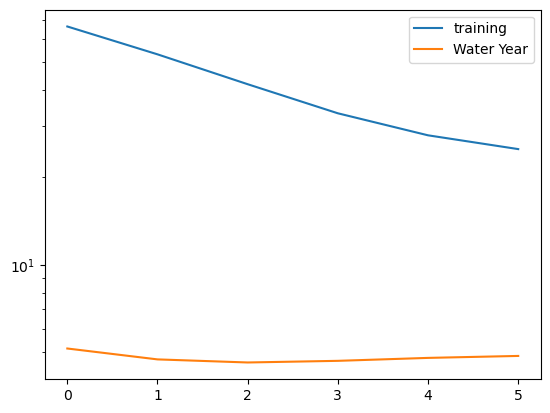

In [ ]:
plt.plot(training_loss_epoch, label='training')
plt.plot(wy_loss_epoch, label='Water Year')
plt.legend()
plt.yscale("log")
plt.savefig("pt1Training_final")

In [ ]:
# Define hyperparameters
num_epochs_all = [300, 564]
batch_size = 1024
learning_rate = 5e-4
torch.manual_seed(789)
device_id = 0
if torch.cuda.is_available():
    device = f"cuda:{device_id}"
else:
    device = 'cpu'
model_prepend = 'pt2'


# Instantiate the GRU model
model = GRU_MME()
model.load_state_dict(torch.load(f"pt1_gru_model_0.pth"))
model.to(device)
# torch.autograd.set_detect_anomaly(True)

# Define loss function and optimizer
mse = nn.MSELoss()
l1 = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_test_years = 5
period = (n_test_years+2)*365+2
daily = pd.read_csv("/home/ScoutJarman/Code/ILWA/data/other/Daily.csv", parse_dates=['date'])
daily_train = daily.iloc[:-period].reset_index(drop=True)
daily_test = daily.iloc[-period:].reset_index(drop=True)
# daily_train = daily.copy()
# daily_test = daily.copy()
# Set up training and testing sets
period = 3

# To have a standard scaler
dataset_train = BearLakeDataset(daily_train, period_days=period*365, use_wateryear=False)
scaler = dataset_train.scaler
dataset_test = BearLakeWaterYear(daily_test, period, scaler)
dataloader_test_wy = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


# Training loop
training_loss_all = []
training_loss_epoch = []
wy_loss_epoch = []
wy_loss = 0
try:
    for i, wateryear in enumerate([True]):
        i = 1
        if wateryear:
            dataset_train = BearLakeWaterYear(daily_train, period, scaler)
            dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        else:
            dataset_train = BearLakeDataset(daily_train, period_days=period*365, use_wateryear=False)
            dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
            
        num_epochs = num_epochs_all[i]
        # Train over epochs
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            tmp_epoch_loss = []
            model.train()
            for batch_X, batch_Ys in dataloader:
                batch_X = batch_X.to(device)
                batch_Ys = batch_Ys.to(device)
                # Forward pass
                outputs, std = model(batch_X)
                # Compute the loss
                loss = mse(outputs, batch_Ys) + l1(outputs, batch_Ys)
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.set_description(f"Train MSE+L1: {loss.item():.2f};\tWater Year L1: {wy_loss:.2f}")
                training_loss_all.append(loss.item())
                tmp_epoch_loss.append(loss.item())
            training_loss_epoch.append(np.mean(tmp_epoch_loss))

            # Eval model
            model.eval()
            with torch.no_grad():
                tmp_loss = 0
                for batch_X, batch_Ys in dataloader_test_wy:
                    batch_X = batch_X.to(device)
                    batch_Ys = batch_Ys.to(device)
                    outputs, std = model(batch_X)
                    
                    loss = l1(outputs, batch_Ys)
                    tmp_loss += loss.item()
                wy_loss_epoch.append(tmp_loss/len(dataloader_test_wy))
            wy_loss = wy_loss_epoch[-1]
            
            # Save the trained model if needed
            torch.save(model.state_dict(), f'{model_prepend}_gru_model_{i}.pth')
except:
    torch.save(model.state_dict(), f'{model_prepend}_gru_model_final.pth')
finally:
    torch.save(model.state_dict(), f'{model_prepend}_gru_model_final.pth')

Train MSE+L1: 1.23;	Water Year L1: 2.69: 100%|██████████| 564/564 [00:36<00:00, 15.63it/s] 


In [ ]:
np.argmin(wy_loss_epoch), np.min(wy_loss_epoch)

(229, 1.341406226158142)

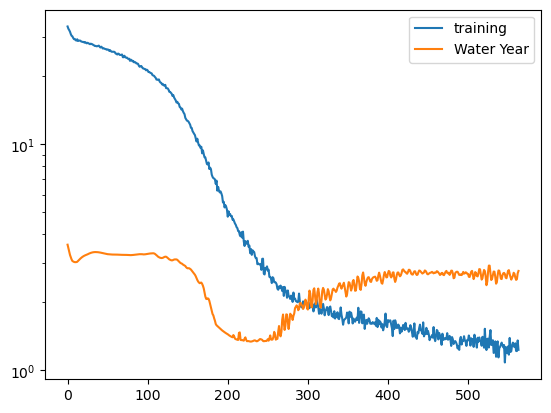

In [ ]:
plt.plot(training_loss_epoch, label='training')
plt.plot(wy_loss_epoch, label='Water Year')
plt.legend()
plt.yscale("log")
plt.savefig("pt2Training_final")

In [ ]:
# torch.manual_seed(789)
# device_id = 0
# if torch.cuda.is_available():
#     device = f"cuda:{device_id}"
# else:
#     device = 'cpu'

# l1 = nn.L1Loss()


# daily = pd.read_csv("/home/ScoutJarman/Code/ILWA/data/other/Daily.csv", parse_dates=['date'])
# # n_test_years = 5
# # period = (n_test_years+2)*365+2
# # daily_train = daily.iloc[:-period].reset_index(drop=True)
# # daily_test = daily.iloc[-period:].reset_index(drop=True)
# daily_train = daily.copy()
# daily_test = daily.copy()
# # Set up training and testing sets
# period = 3

# # To have a standard scaler
# dataset_train = BearLakeDataset(daily_train, period_days=period*365, use_wateryear=False)
# scaler = dataset_train.scaler

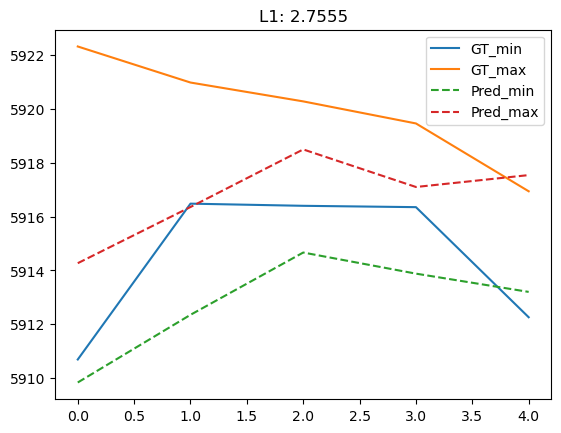

In [ ]:
model = GRU_MME()
model.load_state_dict(torch.load("pt2_gru_model_final.pth"))
model.to('cuda:0')

model.eval()
with torch.no_grad():
    for batch_X, batch_Ys in dataloader_test_wy:
        batch_X = batch_X.to(device)
        batch_Ys = batch_Ys.to(device)
        outputs, std = model(batch_X)
        loss = l1(outputs, batch_Ys)

# print(batch_Ys)
# print(outputs)
plt.plot(batch_Ys.detach().cpu().numpy(), label=['GT_min', 'GT_max'])
plt.plot(outputs.detach().cpu().numpy(), label=['Pred_min', 'Pred_max'], linestyle='--')
plt.legend()
plt.title(f"L1: {loss.item():.4f}")
plt.savefig("Preds_pt2final_final.png")